We will choose DelayMatchSample and ContextDecisionMaking from neurogym to assess our models

In [1]:
# IMPORTS AND SETUPS
import torch
import random
import neurogym as ngym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# ignore gym warnings
warnings.filterwarnings('ignore', module='gymnasium')

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use GPU
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

TASKS = [
    'DelayMatchSample-v0',
    'DelayComparison-v0',
]

# inspect our tasks
for task in TASKS:
    dt = 20 # the dt we want to train with
    env = ngym.make(task, dt=dt)
    dataset = ngym.Dataset(env, batch_size=1, seq_len=1000)
    _, labels = dataset()
    print(f"{task}:")
    print(f"  Timing (ms): {env.timing}")
    print(f"  Total time per trial: {sum(env.timing.values())}")
    print(f"  Total steps per trial: {sum(env.timing.values())/dt}")
    print(f"  Decision labels (!=0): {(labels != 0).sum()} / {labels.size}")
    print(f"  Unique labels: {np.unique(labels)}")
    print(f"  Actions: {env.action_space.n}\n")

DelayMatchSample-v0:
  Timing (ms): {'fixation': 300, 'sample': 500, 'delay': 1000, 'test': 500, 'decision': 900}
  Total time per trial: 3200
  Total steps per trial: 160.0
  Decision labels (!=0): 270 / 1000
  Unique labels: [0 2]
  Actions: 3

DelayComparison-v0:
  Timing (ms): {'fixation': 500, 'stimulus1': 500, 'delay': 1000, 'stimulus2': 500, 'decision': 100}
  Total time per trial: 2600
  Total steps per trial: 130.0
  Decision labels (!=0): 35 / 1000
  Unique labels: [0 1 2]
  Actions: 3



In [2]:
# IMPORT CODE and CONFIGS
from src.experiment import Experiment
import config as cfg

### 2a - Delay Match Sample - RNN vs Sparse-Dale-RNN


TRAINING >>>>>>>>>>>>> vanilla

Building <class 'src.rnn_vanilla.RNNVanilla'> model with hidden size 32
Input size: 3, Output size: 3 
[vanilla] Epoch 0: Loss=1.0640, Acc=0.0000
[vanilla] Epoch 10: Loss=0.5907, Acc=0.0000
[vanilla] Epoch 20: Loss=0.3849, Acc=0.0000
[vanilla] Epoch 30: Loss=0.2426, Acc=0.4792
[vanilla] Epoch 40: Loss=0.2138, Acc=0.4278
[vanilla] Epoch 50: Loss=0.2037, Acc=0.4965
[vanilla] Epoch 60: Loss=0.2068, Acc=0.4632
[vanilla] Epoch 70: Loss=0.2018, Acc=0.4951
[vanilla] Epoch 80: Loss=0.2127, Acc=0.3146
[vanilla] Epoch 90: Loss=0.2083, Acc=0.5299
[vanilla] Epoch 100: Loss=0.2001, Acc=0.5264
[vanilla] Epoch 110: Loss=0.1983, Acc=0.5278
[vanilla] Epoch 120: Loss=0.2000, Acc=0.4674
[vanilla] Epoch 130: Loss=0.1971, Acc=0.5292
[vanilla] Epoch 140: Loss=0.1956, Acc=0.5938

TRAINING >>>>>>>>>>>>> bio

Building <class 'src.rnn_bio.RNNBio'> model with hidden size 32
Input size: 3, Output size: 3 
[bio] Epoch 0: Loss=1.0610, Acc=0.0000
[bio] Epoch 10: Loss=0.6330, Acc=0.00

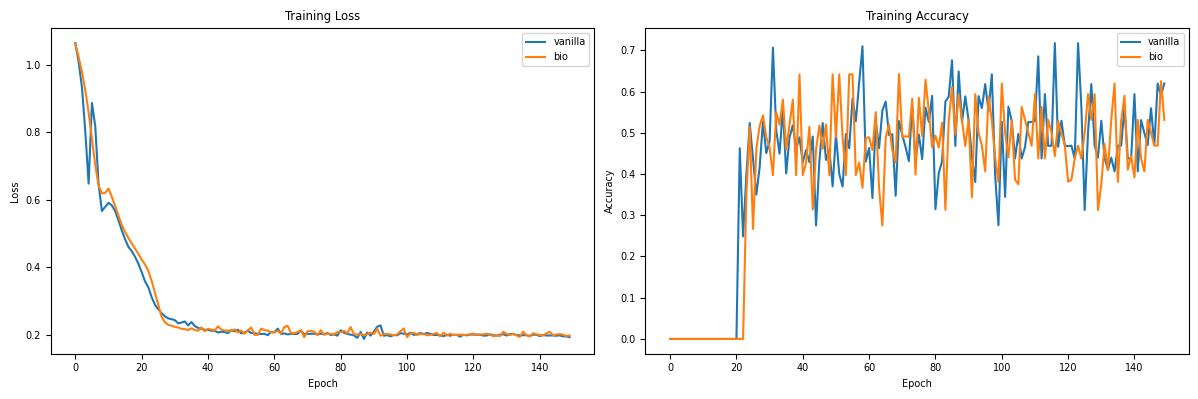

In [3]:
dms = Experiment(TASKS[0], dt=cfg.DT, device=cfg.DEVICE) \
    .compare(
        models_configs=[cfg.RNN_VANILLA, cfg.RNN_BIO], 
        train_configs=cfg.DMS_TRAINING_CONFIGS
    ) \
    .summary() \
    .plot()

### 2b - Models Comparison

In [4]:
def plot_predictions(labels, all_preds, env_name):
    """Plot predictions vs labels during decision periods."""
    n_models = len(all_preds)
    fig, axes = plt.subplots(n_models + 1, 1, figsize=(14, 3 * (n_models + 1)), sharex=True)
    labels_flat = labels[:, 0]
    
    # find decision periods (where label != 0)
    decision_mask = labels_flat != 0
    
    # plot labels
    axes[0].plot(labels_flat, 'k-', linewidth=1, label='Label')
    axes[0].fill_between(range(len(labels_flat)), 0, labels_flat.max(), 
                         where=decision_mask, alpha=0.2, color='green', label='Decision period')
    axes[0].set_ylabel('Label')
    axes[0].set_title(f'{env_name} - Ground Truth')
    axes[0].legend(loc='upper right')
    axes[0].set_ylim(-0.5, labels_flat.max() + 0.5)
    
    # plot each model's predictions
    for i, (name, preds) in enumerate(all_preds.items()):
        preds_flat = preds[:, 0]  # (seq_len,)
        
        # accuracy for this model
        if decision_mask.sum() > 0:
            acc = (preds_flat[decision_mask] == labels_flat[decision_mask]).mean()
        else:
            acc = 0.0
        
        axes[i + 1].plot(preds_flat, 'b-', linewidth=1, alpha=0.7, label='Prediction')
        axes[i + 1].fill_between(
            range(len(labels_flat)), 0, labels_flat.max(),
            where=decision_mask, alpha=0.2, color='coral'
        )
        axes[i + 1].set_ylabel('Prediction')
        axes[i + 1].set_title(f'{name} (Acc: {acc:.4f})')
        axes[i + 1].legend(loc='upper right')
        axes[i + 1].set_ylim(-0.5, labels_flat.max() + 0.5)
    
    axes[-1].set_xlabel('Timestep')
    plt.tight_layout()
    plt.show()

    # separately test trained models from experiment on fresh data gen
def test_models(experiment, num_trials, is_print=False, plot=False):
    """Test all trained models on fresh trials."""
    env = ngym.make(experiment.env_name, dt=experiment.dt)

    trial_time = sum(env.timing.values())
    steps_per_trial = int(trial_time/dt)
    seq_len = steps_per_trial * num_trials
    
    dataset = ngym.Dataset(env, batch_size=1, seq_len=seq_len)
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).float().to(experiment.device)
    labels = torch.from_numpy(labels).long().to(experiment.device)
    
    if is_print:
        print(f"Testing on {num_trials} {experiment.env_name} trials ({seq_len} steps)\n")
    
    res = {}
    all_preds = {}
    for name, model in experiment.models.items():
        model.eval()
        
        with torch.no_grad():
            outputs, _ = model(inputs)
            preds = outputs.argmax(dim=-1)
            
            mask = labels != 0
            if mask.sum() > 0:
                acc = (preds[mask] == labels[mask]).float().mean().item()
            else:
                acc = 0.0
        res[name] = round(acc, 4)
        all_preds[name] = preds.cpu().numpy()
    
    if plot:
        plot_predictions(labels.cpu().numpy(), all_preds, experiment.env_name)
    return res

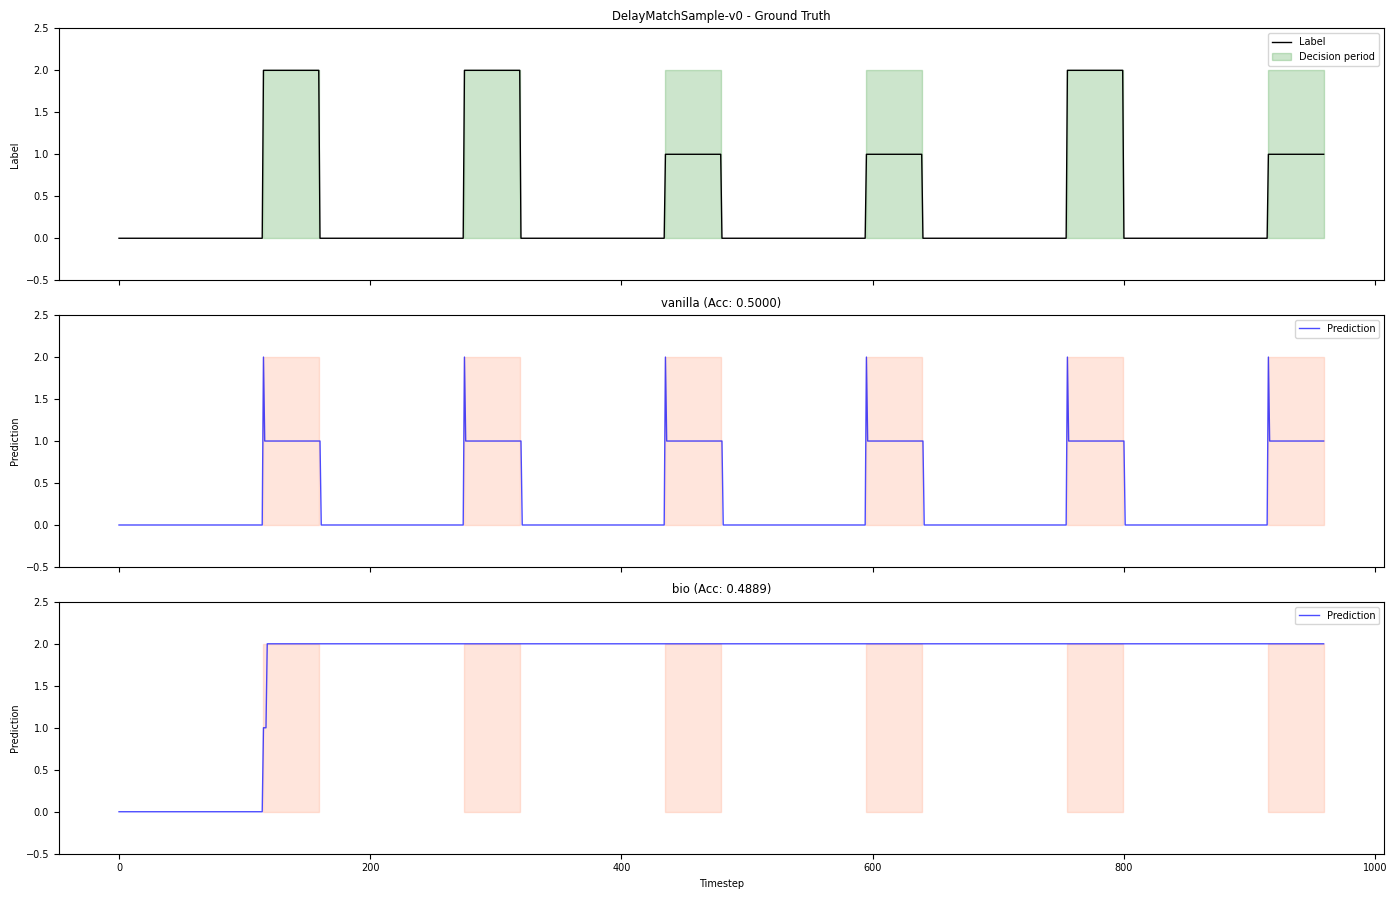

{'vanilla': 0.5, 'bio': 0.4889}

In [7]:
test_models(dms, 6, plot=True)

In [8]:
def plot_hidden_comparison(experiment, r_excitatory=0.8):
    """Compare final hidden states across all models."""
    model_names = list(experiment.hidden_hist.keys())
    n_models = len(model_names)
    
    fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 6))
    
    if n_models == 1:
        axes = axes.reshape(-1, 1)
    
    for i, name in enumerate(model_names):
        # get final epoch
        epochs = sorted(experiment.hidden_hist[name].keys())
        h = experiment.hidden_hist[name][epochs[-1]]  # (seq_len, hidden_size)
        
        # row 1 heatmap
        axes[0, i].imshow(h.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
        axes[0, i].set_xlabel('Time')
        axes[0, i].set_ylabel('Neuron')
        axes[0, i].set_title(f'{name}')
        
        if 'bio' in name.lower() and r_excitatory is not None:
            n_exc = int(h.shape[1] * r_excitatory)
            axes[0, i].axhline(y=n_exc - 0.5, color='black', linestyle='--')
        
        # row 2 mean activation over time
        if 'bio' in name.lower() and r_excitatory is not None:
            n_exc = int(h.shape[1] * r_excitatory)
            axes[1, i].plot(h[:, :n_exc].mean(axis=1), label='Excitatory', color='blue')
            axes[1, i].plot(h[:, n_exc:].mean(axis=1), label='Inhibitory', color='red')
            axes[1, i].legend()
        else:
            axes[1, i].plot(h.mean(axis=1), color='blue')
        axes[1, i].set_xlabel('Time')
        axes[1, i].set_ylabel('Mean activation')
    
    plt.tight_layout()
    plt.show()

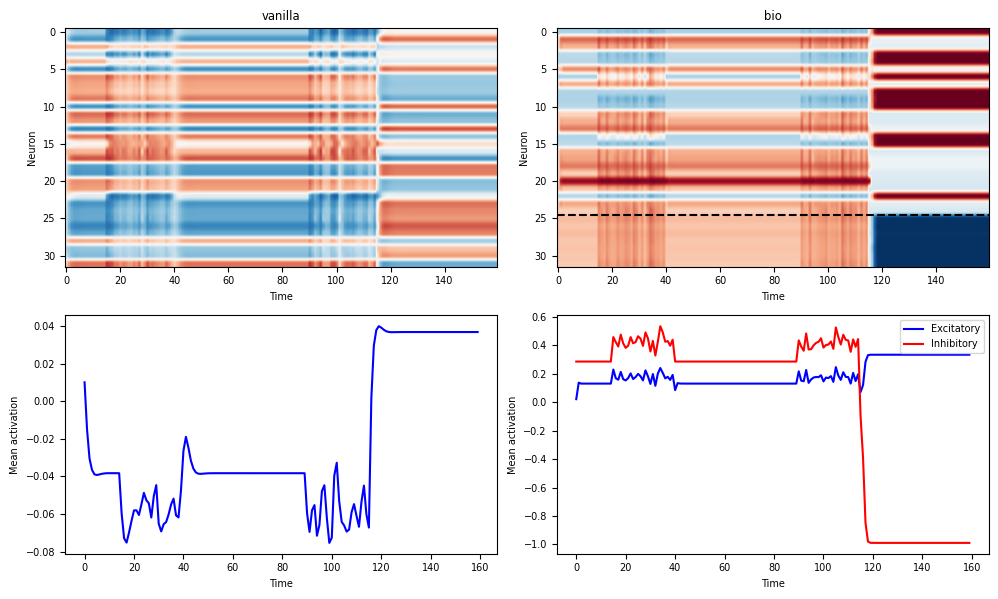

In [9]:
plot_hidden_comparison(dms, r_excitatory=0.8)

### 2c - DelayComparison


TRAINING >>>>>>>>>>>>> vanilla

Building <class 'src.rnn_vanilla.RNNVanilla'> model with hidden size 32
Input size: 2, Output size: 3 
[vanilla] Epoch 0: Loss=1.1168, Acc=0.4531
[vanilla] Epoch 10: Loss=0.2612, Acc=0.0000
[vanilla] Epoch 20: Loss=0.1932, Acc=0.0000
[vanilla] Epoch 30: Loss=0.1914, Acc=0.0000
[vanilla] Epoch 40: Loss=0.1920, Acc=0.0000
[vanilla] Epoch 50: Loss=0.1900, Acc=0.0000
[vanilla] Epoch 60: Loss=0.1893, Acc=0.0000
[vanilla] Epoch 70: Loss=0.1869, Acc=0.0000
[vanilla] Epoch 80: Loss=0.1804, Acc=0.0000
[vanilla] Epoch 90: Loss=0.1635, Acc=0.0000
[vanilla] Epoch 100: Loss=0.1416, Acc=0.0000
[vanilla] Epoch 110: Loss=0.0916, Acc=0.2531
[vanilla] Epoch 120: Loss=0.0620, Acc=0.3187
[vanilla] Epoch 130: Loss=0.0498, Acc=0.4750
[vanilla] Epoch 140: Loss=0.0440, Acc=0.4031
[vanilla] Epoch 150: Loss=0.0396, Acc=0.3563
[vanilla] Epoch 160: Loss=0.0366, Acc=0.4437
[vanilla] Epoch 170: Loss=0.0338, Acc=0.4375
[vanilla] Epoch 180: Loss=0.0322, Acc=0.4531
[vanilla] Epoch 190:

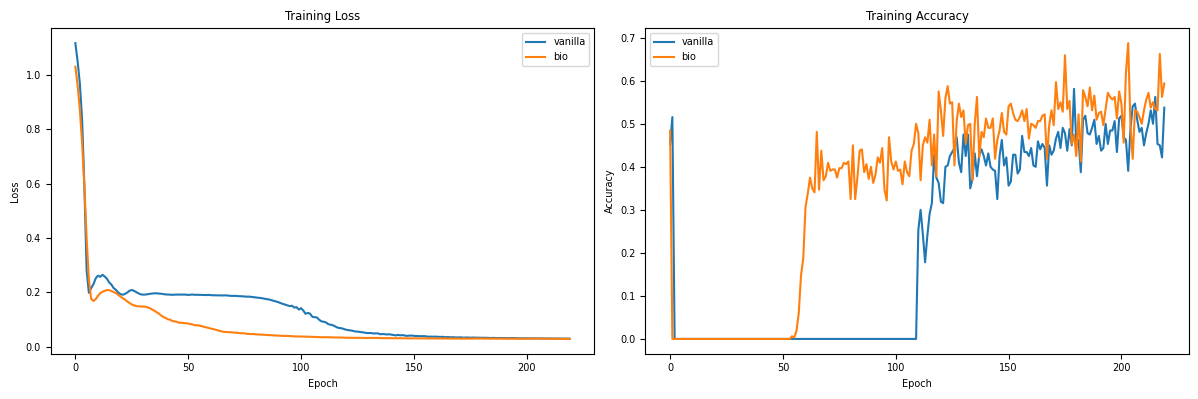

In [10]:
dc = Experiment(TASKS[1], dt=cfg.DT, device=cfg.DEVICE) \
    .compare(
        models_configs=[cfg.RNN_VANILLA, cfg.RNN_BIO], 
        train_configs=cfg.DC_TRAINING_CONFIGS
    ) \
    .summary() \
    .plot()

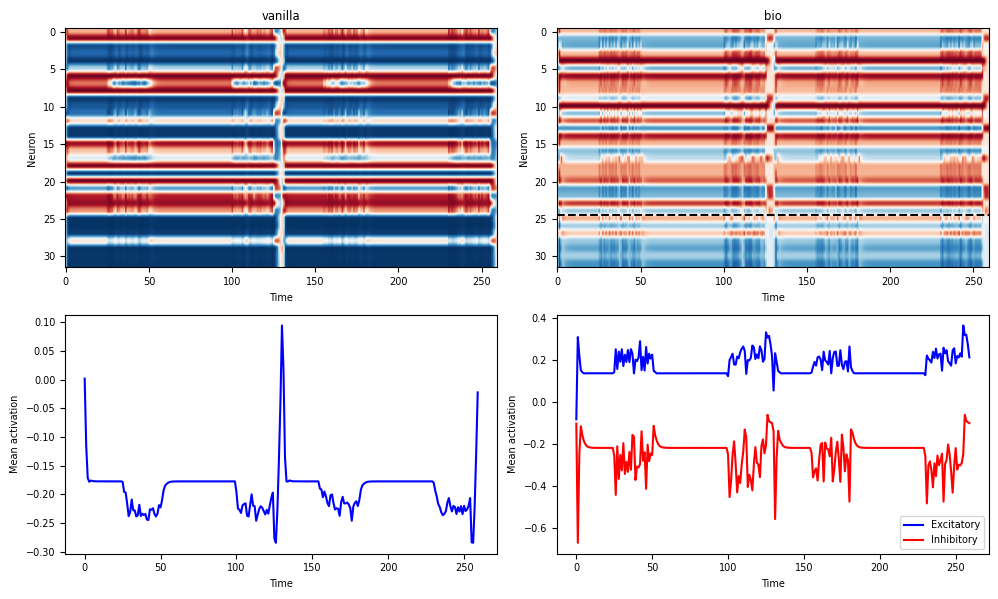

In [11]:
plot_hidden_comparison(dc, r_excitatory=0.8)

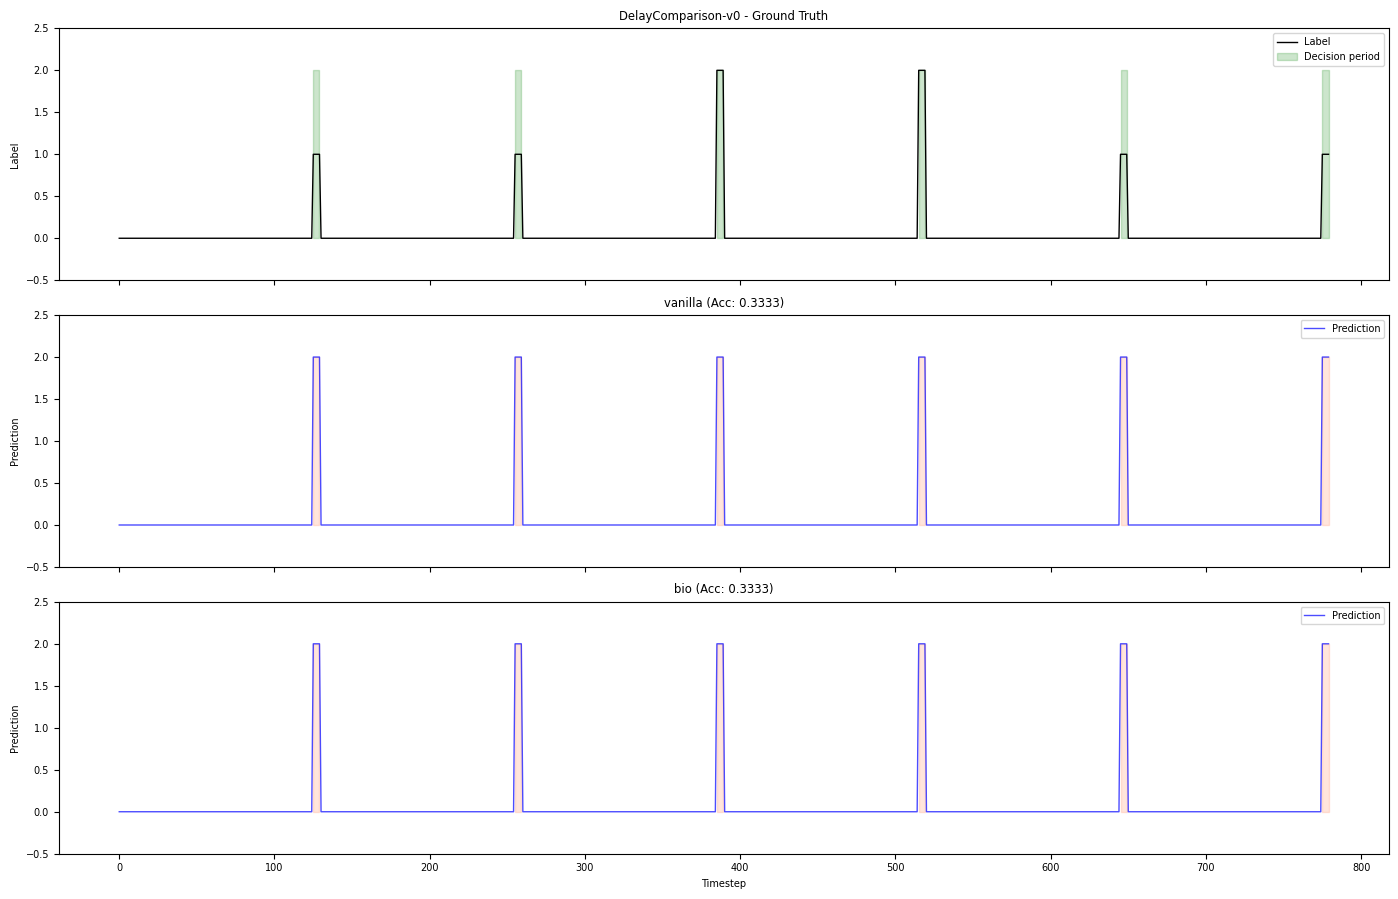

{'vanilla': 0.3333, 'bio': 0.3333}

In [17]:
test_models(dc, 6, plot=True)

### 2d - Repeated Testing and Ensemble Voting

In [18]:
# test multiple times
runs = 20
results = []
for r in range(runs):
    results.append(test_models(dms, 3))
# show test accuracy distribution
res_df = pd.DataFrame(results)
res_df.describe()

,vanilla,bio
count,20.000000,20.000000
mean,0.451850,0.552230
std,0.214491,0.213534
min,0.014800,0.311100
25%,0.340700,0.355600
50%,0.340700,0.644400
75%,0.659300,0.688900
max,0.659300,0.977800


In [19]:
# building an ensemble of agents and let them vote to see if results can be improved
def ensemble_predict(models, inputs):
    """
    Get predictions from multiple models and vote.
    """
    all_preds = []
    
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs, _ = model(inputs)
            preds = outputs.argmax(dim=-1)
            all_preds.append(preds)
    
    all_preds = torch.stack(all_preds, dim=0)
    voted_preds, _ = torch.mode(all_preds, dim=0)
    
    return voted_preds, all_preds


def ensemble_test(models, env_name, dt=20, num_trials=3, device='cpu'):
    """Test ensemble on fresh data."""
    env = ngym.make(env_name, dt=dt)
    trial_time = sum(env.timing.values())
    steps_per_trial = int(trial_time/dt)
    seq_len = steps_per_trial * num_trials
    
    dataset = ngym.Dataset(env, batch_size=32, seq_len=seq_len)
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).float().to(device)
    labels = torch.from_numpy(labels).long().to(device)
    
    # get ensemble prediction
    voted_preds, all_preds = ensemble_predict(models, inputs)
    
    # ensemble accuracy
    mask = labels != 0
    ensemble_acc = (voted_preds[mask] == labels[mask]).float().mean().item()
    
    # individual model accuracies
    individual_accs = []
    for i in range(len(models)):
        acc = (all_preds[i][mask] == labels[mask]).float().mean().item()
        individual_accs.append(acc)
    
    print(f"Individual accuracies: {[f'{a:.4f}' for a in individual_accs]}")
    print(f"Ensemble accuracy: {ensemble_acc:.4f}")
    print(f"Best individual: {max(individual_accs):.4f}")

In [20]:
num_agents = 10

# build configs
train_bio_conf = {
    'seq_len': 160,
    'l1_lambda': 0.001,
    'epochs': 150, # reduce epoch for speed
    'lr': 0.001,
}
bio_confs = []
train_confs = {}

# mass produce agents
for i in range(num_agents):
    agent_name = f'bio_{i}'
    agent_conf = {**cfg.RNN_BIO, 'name': agent_name}
    bio_confs.append(agent_conf)
    train_confs[agent_name] = train_bio_conf
# checks
print(len(bio_confs), len(train_confs))
print(bio_confs[5])
print(train_confs[f'bio_5'])

10 10
{'name': 'bio_5', 'rnn_class': <class 'src.rnn_bio.RNNBio'>, 'hidden_size': 32, 'r_excitatory': 0.8}
{'seq_len': 160, 'l1_lambda': 0.001, 'epochs': 150, 'lr': 0.001}


In [21]:
# try agents ensemble on DMS
dms_ens = Experiment(TASKS[0], dt=cfg.DT, device=cfg.DEVICE) \
    .compare(
        models_configs=bio_confs, 
        train_configs=train_confs
    ) \
    .summary()


TRAINING >>>>>>>>>>>>> bio_0

Building <class 'src.rnn_bio.RNNBio'> model with hidden size 32
Input size: 3, Output size: 3 
[bio_0] Epoch 0: Loss=1.1601, Acc=0.5312
[bio_0] Epoch 10: Loss=1.0966, Acc=0.4688
[bio_0] Epoch 20: Loss=1.0209, Acc=0.6111
[bio_0] Epoch 30: Loss=0.9159, Acc=0.0000
[bio_0] Epoch 40: Loss=0.7589, Acc=0.0000
[bio_0] Epoch 50: Loss=0.6283, Acc=0.0000
[bio_0] Epoch 60: Loss=0.6095, Acc=0.0000
[bio_0] Epoch 70: Loss=0.5757, Acc=0.0000
[bio_0] Epoch 80: Loss=0.5403, Acc=0.0000
[bio_0] Epoch 90: Loss=0.5085, Acc=0.0000
[bio_0] Epoch 100: Loss=0.4726, Acc=0.0000
[bio_0] Epoch 110: Loss=0.4309, Acc=0.0000
[bio_0] Epoch 120: Loss=0.4056, Acc=0.4111
[bio_0] Epoch 130: Loss=0.3902, Acc=0.5806
[bio_0] Epoch 140: Loss=0.3808, Acc=0.4979

TRAINING >>>>>>>>>>>>> bio_1

Building <class 'src.rnn_bio.RNNBio'> model with hidden size 32
Input size: 3, Output size: 3 
[bio_1] Epoch 0: Loss=1.1344, Acc=0.5312
[bio_1] Epoch 10: Loss=1.0797, Acc=0.5625
[bio_1] Epoch 20: Loss=1.0185, 

In [ ]:
ensemble_test(
    models=dms_ens.models.values(),
    env_name=TASKS[0],
    dt=cfg.DT,
    num_trials=3,
    device=cfg.DEVICE
)